In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from time import time
import matplotlib
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
from sklearn.decomposition import PCA
tf.keras.backend.set_floatx('float64')
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
%matplotlib inline
print("tensorflow version: ", tf.__version__)
print("numpy version: ", np.__version__)
print("matplotlib version: ", matplotlib.__version__)
print("sklearn version: ", sklearn.__version__)

tensorflow version:  2.2.0
numpy version:  1.18.1
matplotlib version:  3.1.1
sklearn version:  0.21.3


<center> <h1> Creating the utils for the project</h1>

<b>Autor:</b> Edwin Rueda <br>
<b>email:</b> ejrueda95g@gmail.com <br>
<b>github:</b> https://github.com/ejrueda <br>
<b>website:</b> http://edwinrueda.com/ <br>
<b> You can cite this work with</b>:

@software{edwin_rueda_2020_3843381,<br>
  author       = {Edwin Rueda},<br>
  title        = {ejrueda/MasterUFPA: zenodo release},<br>
  month        = may,<br>
  year         = 2020,<br>
  publisher    = {Zenodo},<br>
  version      = {zenodo},<br>
  doi          = {10.5281/zenodo.3843381},<br>
  url          = {https://doi.org/10.5281/zenodo.3843381}<br>
}

### scaler
- The scaler class make a minmaxscaler operation in a dataframe, this allows that the dataframe keep your index.
- Parameters:
    - xmin: the min value of the scale
    - xmax: the max value of the scale
- Equation:
    - this scaling is computed by:
$$X_{new} = \frac{x-min(x)}{max(x) - min(x)} *(x_{max}-x_{min}) + x_{min}$$      

    where $x$ represents the dataframe, and $min(x)$ and $max(x)$, represents the minimum and maximum values per column in the dataframe.

In [2]:
class scaler:
    def __init__(self, xmin, xmax):
        """
        minmax scaler from dataframe
        """
        self.xmin = xmin
        self.xmax = xmax
        self.min_data = False
        self.max_data = False
        self.flag = False
        
    def fit(self, X):
        self.min_data = np.min(X).values
        self.max_data = np.max(X).values
        self.flag = True
        
    def transform(self, X):
        assert self.flag, "Erro de treinamento, primeiro tem que treinar o Scaler, called .fit()"
        X_r = X.copy()
        X_r = ((X_r - self.min_data)/(self.max_data - self.min_data))*(self.xmax-self.xmin) + self.xmin
        return X_r
    
    def inverse_transform(self, X):
        assert self.flag, "Erro de treinamento, primeiro tem que treinar o Scaler, called .fit()"
        X_r = X.copy()
        X_r = ((X_r - self.xmin)*(self.max_data - self.min_data)/(self.xmax - self.xmin)) + self.min_data
        return X_r

### Gan utils
- Gan utils is the class to create, train and evaluate the performance of a GAN architecture.

- Functions:
    - <b>kl_divergence:</b> compute the Kullback-Leibler divergence of the Discriminator network.
        - <b>parameters:</b>
            - <b>probability:</b> the probability of the discriminator network.
    - <b>train_gan:</b> this fuction combine the generator and discriminator networks and train the gan architecture. Note that this utils implements the tensorflow library, therefore, the G and D networks are not compiled, you just have to pass the networks without compile.
        - <b>parameters:</b>
            - <b>dataset:</b> a dataset to train the gan architecture, must be a tensorflow dataset.
            - <b>G:</b> generator model without training.
            - <b>D:</b> discriminator model without training.
            - <b>epochs:</b> number of epochs to train de gan architecture.
            - <b>batch_size:</b> the size of the batch to train de gan architecture.
            - <b>loss_function:</b> the loss funtion, in this case, this architecture must employ the binary_cross_entropy loss function.
        - <b>return:</b>
            - <b>accumulated_g_loss:</b> the generator loss by epochs in the architecture.
            - <b>accumulated_d_loss:</b> the discriminator loss by epochs in the architecture.
    - <b>train_step:</b> this function train the architecture over one batch. Note that this function is a tensorflow function.
        - <b>parameters:</b>
            - <b>sample:</b> batch to train the architecture. this batch must be a tensorflow batch.
            - <b>batch_size:</b> the size of the batch to train the architecture.
            - <b>loss_function:</b> the loss function of the architecture. Note that in these architectures, the loss function must be a binary_cross_entropy function.
            - <b>noise_input:</b> the size of the noise vector to train de generator network. In this approach, the noise vector is based in a normal distribution $N(0,1)$.
        - <b>return:</b>
            - <b>gen_loss:</b> the batch loss in the generator network.
            - <b>dis_loss:</b> the batch loss in the discriminator network.
    - <b>plot_results:</b> this function plots four different figures. 1) the cost function of the arquitecture. 2) the kullback-leibler divergence. 3) the precision of the D network. 4) the 2-PCA representation of the synthetic samples.
        - <b>parameters:</b>
            - <b>syn_size:</b> the number of synthetic samples to be generated.
        - <b>return:</b> 
            - <b>p:</b> plot containing the four figures.

In [3]:
class gan_utils:
    
    def __init__(self):
        self.accumulated_gloss = []
        self.accumulated_dloss = []
        self.precision = []
        self.recall = []
        self.kl_d = []
        self.X_train = None
        self.G = None
        self.D = None
        self.noise_input = None
    
    @tf.function
    def kl_divergence(self, probability):
        probability = tf.clip_by_value(probability, 1e-5, 1-1e-5)
        return tf.reduce_mean(probability*tf.math.log(probability/(1-probability)))
    
    @tf.function
    def binary_cross_entropy(self, prediction, target):
        """
        compute the loss for binary clasification problems
        """
        prediction = tf.clip_by_value(prediction, 1e-5, 1-1e-5)
        return -tf.reduce_mean(target*tf.math.log(prediction) + (1-target)*tf.math.log(1-prediction))

    @tf.function
    def train_step(self, sample, batch_size, noise_input, optimizerG, optimizerD):
        noise = tf.random.normal([batch_size, noise_input])
        with tf.GradientTape() as gG, tf.GradientTape() as gD:
            synthetic_data = self.G(noise, training=True)

            real_output = self.D(sample, training=True)
            fake_output = self.D(synthetic_data, training=True)

            gen_loss = self.binary_cross_entropy(fake_output, tf.ones_like(fake_output))
            dis_loss = .5*(self.binary_cross_entropy(real_output, tf.ones_like(real_output)) + self.binary_cross_entropy(fake_output,tf.zeros_like(fake_output)))

        g_generator = gG.gradient(gen_loss, self.G.trainable_variables)
        g_discriminator = gD.gradient(dis_loss, self.D.trainable_variables)

        optimizerG.apply_gradients(zip(g_generator, self.G.trainable_variables))
        optimizerD.apply_gradients(zip(g_discriminator, self.D.trainable_variables))

        return gen_loss, dis_loss
    
    def train(self, dataset, G, D, noise_input, epochs, batch_size, optimizerG, optimizerD):
        #reset metrics
        self.accumulated_gloss = []
        self.accumulated_dloss = []
        self.precision = []
        self.recall = []
        self.kld = []
        batch_g_loss = []
        batch_d_loss = []
        self.G, self.D = G, D
        self.noise_input = noise_input
        self.X_train = dataset
        batches = tf.data.Dataset.from_tensor_slices(dataset).batch(batch_size)
        for epoch in range(epochs):
            t_i = time()
            for batch in batches:
                batch_g_loss, batch_d_loss = self.train_step(batch, batch_size, noise_input,
                                                             optimizerG, optimizerD)
            self.accumulated_dloss.append(tf.reduce_mean(batch_d_loss))
            self.accumulated_gloss.append(tf.reduce_mean(batch_g_loss))

            X_sint = G(tf.random_normal_initializer(mean=0.0, stddev=1)([batch_size,noise_input],
                                                                        dtype=tf.float64))
            X_comb = tf.concat([dataset, X_sint], axis=0)
            y_comb = tf.concat([tf.ones((dataset.shape[0],1)), np.zeros((X_sint.shape[0],1))], axis=0)
            y_proba = D(X_comb)
            y_predict = tf.reshape((tf.greater(y_proba, .5).numpy()*1), [-1])
            self.kl_d.append(self.kl_divergence(y_proba).numpy())
            self.precision.append(precision_score(y_comb.numpy(), y_predict.numpy()))
            self.recall.append(recall_score(y_comb.numpy(), y_predict.numpy()))
            t_f = time()
            
            print("epochs[%d:%d] :: G_loss[%f] :: D_loss[%f] :: time:%f[s]"%(epoch, epochs,
                                                                             self.accumulated_gloss[-1],
                                                                             self.accumulated_dloss[-1],
                                                                             t_f-t_i))
        return self.accumulated_gloss, self.accumulated_dloss
        
    def plot_results(self, syn_size):
        fig = plt.figure(figsize=(15,10))
        for i in range(4):
            plt.subplot(2,2, i+1)
            if i==0:
                rr = range(0,len(self.accumulated_gloss), 3)
                short_g_loss = [self.accumulated_gloss[i] for i in rr]
                short_d_loss = [self.accumulated_dloss[i] for i in rr]
                plt.plot(rr, short_g_loss, label="Generator", color="#FFB248")
                plt.plot(rr, short_d_loss, label="Discriminator", color="#5F84B4")
                plt.xlabel("Epochs", fontsize=13)
                plt.ylabel("Loss", fontsize=13)
                plt.grid(axis="y")
                plt.legend();
            elif i==1:
                plt.title("Divergencia de Kullback-Leibler", fontsize=14)
                plt.plot(range(len(self.kl_d)), self.kl_d, linewidth=.5)
                plt.plot(range(len(self.kl_d)), np.zeros(len(self.kl_d)))
                plt.grid()
                plt.xlabel("Epochs");
                plt.ylabel("Divergencia de Kullback-Leibler");
            elif i==2:
                short_precision = [self.precision[v] for v in rr]
                plt.plot(rr, short_precision, linewidth=.8, label="precision")
                plt.grid(axis="y")
                plt.plot(rr, np.ones(len(short_precision))*.5,
                         label="target", linestyle="--")
                plt.legend();
            elif i==3:
                pca = PCA(n_components=2)
                X_real_pca = pca.fit_transform(self.X_train.numpy())
                noise = tf.random.normal([syn_size, self.noise_input])
                synthetics = self.G(noise)
                X_fake_pca = pca.transform(synthetics.numpy())
                plt.scatter(X_fake_pca[:,0], X_fake_pca[:,1], label="synthetic", alpha=.4, color="orange",
                           edgecolors="red");
                plt.scatter(X_real_pca[:,0], X_real_pca[:,1], label="real", marker="*", s=80, color="green",
                            edgecolors="black");
        return fig
    
    
    def get_metrics(self, num_iter):
        """
        this function returns the metrics obtained after
        training the architecture
        num_iter: number of iterations to compute the boxplot
        return: precision of the discriminator network, Kullback-Leibler divergence
                loss of the generator network, loss of the discriminator network
        """
        precision_d = []
        kld_divergence = []
        g_loss = []
        d_loss = []
        for i in range(num_iter):
            noise = tf.random.normal([self.X_train.shape[0], self.noise_input])
            synthetic_samples = self.G(noise)
            X_comb = tf.concat([self.X_train, synthetic_samples], axis=0)
            y_comb = tf.concat([tf.ones((self.X_train.shape[0],1), dtype=tf.float64),
                                tf.zeros((synthetic_samples.shape[0],1), dtype=tf.float64)], axis=0)
            y_proba = self.D(X_comb)
            y_predict = tf.reshape((tf.greater(y_proba, .5).numpy()*1), [-1])
            precision_d.append(precision_score(y_comb.numpy(), y_predict))
            kld_divergence.append(self.kl_divergence(y_proba).numpy())
            g_loss.append(self.binary_cross_entropy(self.D(synthetic_samples),
                                                    tf.zeros(synthetic_samples.shape[0], dtype=tf.float64)).numpy())
            d_loss.append(self.binary_cross_entropy(y_proba, y_comb).numpy())
            
        return precision_d, kld_divergence, g_loss, d_loss

###  Test

In [4]:
data = pd.read_csv("../data/all_counts_9_norm_rpkm_log2_preprocessed.csv",
                  index_col=0)
r_g = open("../data/reference_genes.txt").read().splitlines()
r_g.remove("idnT")
X_train = data.loc[r_g]
X_train.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
hcaT,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
rrsA,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
ihfB,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441
ssrA,12.889916,13.026561,13.839784,14.807551,14.601034,13.858224,14.509441,12.713618,13.816964


In [5]:
obj_scaler = scaler(xmin=-1, xmax=1)
obj_scaler.fit(X_train)
X_train = obj_scaler.transform(X_train)
X_train.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377


In [6]:
X_train = tf.Variable(np.array(X_train))

In [7]:
noise_input = 50

In [8]:
@tf.function
def my_binary_cross_entropy(prediction, target):
    """
    compute the loss for binary clasification problems
    """
    prediction = tf.clip_by_value(prediction, 1e-5, 1-1e-5)
    return -tf.reduce_mean(target*tf.math.log(prediction) + (1-target)*tf.math.log(1-prediction))

In [9]:
G = Sequential()
G.add(Dense(noise_input, input_shape=(noise_input,)))
G.add(Dense(50)) #64
G.add(Dense(150)) #64
G.add(tf.keras.layers.Dropout(.15))
G.add(Dense(9, activation="tanh"))

D = Sequential()
D.add(Dense(32, input_shape=(9,)))
D.add(tf.keras.layers.LeakyReLU(alpha=.2)) #función rectificadora
D.add(Dense(32))
#D.add(tf.keras.layers.Dropout(.1))
D.add(Dense(1, activation='sigmoid'))

In [10]:
noise = tf.random_normal_initializer(mean=0.0, stddev=1)([1,noise_input], dtype=tf.float64)
print("shape of the input noise:", noise.shape)
synthetic_sample = G(noise)
print("shape of the synthetic sample:", synthetic_sample.shape)
print("prediction of the D network:", D(synthetic_sample))
#print("loss of the D network:", my_binary_cross_entropy(D(synthetic_sample), 0))

shape of the input noise: (1, 50)
shape of the synthetic sample: (1, 9)
prediction of the D network: tf.Tensor([[0.42378476]], shape=(1, 1), dtype=float64)


In [11]:
batch_size = 20
ep = 1700
#optimizerG = tf.optimizers.SGD(lr=0.00014, momentum=0.92, decay=0.00014/ep)
#optimizerD = tf.optimizers.SGD(lr=0.0011, momentum=0.9, decay=0.0011/ep)

optimizerG = tf.optimizers.SGD(lr=0.00015, momentum=0.92, decay=0.00015/ep)
optimizerD = tf.optimizers.SGD(lr=0.0011, momentum=0.9, decay=0.0011/ep)

In [12]:
utils = gan_utils()
gloss, dloss = utils.train(X_train, G, D, noise_input, ep, batch_size, optimizerG, optimizerD)

epochs[0:1700] :: G_loss[0.891380] :: D_loss[0.713105] :: time:1.069883[s]
epochs[1:1700] :: G_loss[0.805992] :: D_loss[0.736508] :: time:0.008373[s]
epochs[2:1700] :: G_loss[0.872294] :: D_loss[0.714614] :: time:0.008177[s]
epochs[3:1700] :: G_loss[0.955819] :: D_loss[0.684138] :: time:0.008254[s]
epochs[4:1700] :: G_loss[0.835479] :: D_loss[0.729537] :: time:0.008124[s]
epochs[5:1700] :: G_loss[0.791630] :: D_loss[0.740129] :: time:0.008088[s]
epochs[6:1700] :: G_loss[0.726063] :: D_loss[0.766765] :: time:0.008128[s]
epochs[7:1700] :: G_loss[0.874360] :: D_loss[0.699613] :: time:0.008253[s]
epochs[8:1700] :: G_loss[0.838772] :: D_loss[0.712155] :: time:0.008110[s]
epochs[9:1700] :: G_loss[0.789700] :: D_loss[0.737888] :: time:0.008124[s]
epochs[10:1700] :: G_loss[0.790882] :: D_loss[0.727670] :: time:0.008113[s]
epochs[11:1700] :: G_loss[0.903701] :: D_loss[0.685101] :: time:0.008227[s]
epochs[12:1700] :: G_loss[0.816924] :: D_loss[0.712090] :: time:0.008100[s]
epochs[13:1700] :: G_l

epochs[118:1700] :: G_loss[0.891709] :: D_loss[0.575533] :: time:0.008719[s]
epochs[119:1700] :: G_loss[0.751134] :: D_loss[0.632331] :: time:0.009019[s]
epochs[120:1700] :: G_loss[0.718937] :: D_loss[0.654154] :: time:0.016732[s]
epochs[121:1700] :: G_loss[0.782863] :: D_loss[0.620409] :: time:0.011847[s]
epochs[122:1700] :: G_loss[0.741644] :: D_loss[0.637556] :: time:0.013567[s]
epochs[123:1700] :: G_loss[0.794825] :: D_loss[0.615116] :: time:0.010356[s]
epochs[124:1700] :: G_loss[0.705441] :: D_loss[0.652213] :: time:0.008357[s]
epochs[125:1700] :: G_loss[0.748608] :: D_loss[0.630939] :: time:0.008254[s]
epochs[126:1700] :: G_loss[0.747563] :: D_loss[0.632440] :: time:0.008232[s]
epochs[127:1700] :: G_loss[0.683350] :: D_loss[0.663881] :: time:0.008338[s]
epochs[128:1700] :: G_loss[0.786848] :: D_loss[0.625182] :: time:0.008290[s]
epochs[129:1700] :: G_loss[0.750023] :: D_loss[0.627823] :: time:0.008230[s]
epochs[130:1700] :: G_loss[0.772992] :: D_loss[0.621743] :: time:0.008265[s]

epochs[234:1700] :: G_loss[0.779323] :: D_loss[0.618460] :: time:0.010813[s]
epochs[235:1700] :: G_loss[0.732848] :: D_loss[0.640461] :: time:0.011738[s]
epochs[236:1700] :: G_loss[0.747484] :: D_loss[0.627428] :: time:0.010605[s]
epochs[237:1700] :: G_loss[0.766933] :: D_loss[0.624230] :: time:0.008582[s]
epochs[238:1700] :: G_loss[0.863839] :: D_loss[0.587103] :: time:0.008503[s]
epochs[239:1700] :: G_loss[0.720118] :: D_loss[0.643062] :: time:0.008346[s]
epochs[240:1700] :: G_loss[0.817997] :: D_loss[0.602714] :: time:0.008260[s]
epochs[241:1700] :: G_loss[0.866863] :: D_loss[0.577318] :: time:0.008170[s]
epochs[242:1700] :: G_loss[0.744134] :: D_loss[0.641707] :: time:0.008215[s]
epochs[243:1700] :: G_loss[0.804851] :: D_loss[0.602045] :: time:0.008239[s]
epochs[244:1700] :: G_loss[0.758333] :: D_loss[0.625471] :: time:0.008987[s]
epochs[245:1700] :: G_loss[0.864858] :: D_loss[0.581371] :: time:0.008874[s]
epochs[246:1700] :: G_loss[0.789923] :: D_loss[0.614727] :: time:0.008108[s]

epochs[353:1700] :: G_loss[0.840162] :: D_loss[0.597958] :: time:0.009631[s]
epochs[354:1700] :: G_loss[0.794423] :: D_loss[0.614366] :: time:0.010054[s]
epochs[355:1700] :: G_loss[0.859436] :: D_loss[0.581578] :: time:0.010521[s]
epochs[356:1700] :: G_loss[0.805368] :: D_loss[0.623569] :: time:0.008267[s]
epochs[357:1700] :: G_loss[0.789647] :: D_loss[0.612015] :: time:0.008132[s]
epochs[358:1700] :: G_loss[0.800461] :: D_loss[0.601015] :: time:0.008401[s]
epochs[359:1700] :: G_loss[0.770211] :: D_loss[0.617408] :: time:0.008745[s]
epochs[360:1700] :: G_loss[0.792185] :: D_loss[0.608503] :: time:0.008469[s]
epochs[361:1700] :: G_loss[0.786346] :: D_loss[0.612287] :: time:0.008241[s]
epochs[362:1700] :: G_loss[0.767268] :: D_loss[0.632000] :: time:0.008518[s]
epochs[363:1700] :: G_loss[0.798472] :: D_loss[0.608474] :: time:0.008299[s]
epochs[364:1700] :: G_loss[0.827572] :: D_loss[0.600424] :: time:0.008488[s]
epochs[365:1700] :: G_loss[0.760276] :: D_loss[0.623895] :: time:0.008191[s]

epochs[473:1700] :: G_loss[0.791488] :: D_loss[0.614316] :: time:0.009525[s]
epochs[474:1700] :: G_loss[0.772529] :: D_loss[0.622933] :: time:0.012612[s]
epochs[475:1700] :: G_loss[0.831448] :: D_loss[0.599495] :: time:0.008293[s]
epochs[476:1700] :: G_loss[0.785088] :: D_loss[0.618988] :: time:0.008510[s]
epochs[477:1700] :: G_loss[0.886163] :: D_loss[0.575648] :: time:0.008435[s]
epochs[478:1700] :: G_loss[0.920762] :: D_loss[0.565221] :: time:0.008202[s]
epochs[479:1700] :: G_loss[0.855439] :: D_loss[0.593129] :: time:0.008251[s]
epochs[480:1700] :: G_loss[0.809701] :: D_loss[0.610918] :: time:0.008308[s]
epochs[481:1700] :: G_loss[0.829300] :: D_loss[0.599020] :: time:0.008224[s]
epochs[482:1700] :: G_loss[0.884539] :: D_loss[0.578765] :: time:0.008209[s]
epochs[483:1700] :: G_loss[0.821184] :: D_loss[0.608355] :: time:0.008667[s]
epochs[484:1700] :: G_loss[0.782436] :: D_loss[0.627173] :: time:0.008441[s]
epochs[485:1700] :: G_loss[0.870678] :: D_loss[0.589173] :: time:0.008866[s]

epochs[593:1700] :: G_loss[0.825660] :: D_loss[0.614152] :: time:0.009648[s]
epochs[594:1700] :: G_loss[0.881287] :: D_loss[0.583339] :: time:0.013124[s]
epochs[595:1700] :: G_loss[0.863558] :: D_loss[0.588973] :: time:0.008174[s]
epochs[596:1700] :: G_loss[0.801530] :: D_loss[0.621379] :: time:0.008524[s]
epochs[597:1700] :: G_loss[0.837673] :: D_loss[0.606272] :: time:0.008313[s]
epochs[598:1700] :: G_loss[0.774911] :: D_loss[0.640901] :: time:0.008382[s]
epochs[599:1700] :: G_loss[0.811230] :: D_loss[0.613619] :: time:0.008355[s]
epochs[600:1700] :: G_loss[0.762177] :: D_loss[0.629256] :: time:0.008206[s]
epochs[601:1700] :: G_loss[0.804009] :: D_loss[0.627406] :: time:0.008245[s]
epochs[602:1700] :: G_loss[0.843788] :: D_loss[0.607359] :: time:0.008307[s]
epochs[603:1700] :: G_loss[0.857913] :: D_loss[0.600313] :: time:0.008246[s]
epochs[604:1700] :: G_loss[0.901739] :: D_loss[0.580346] :: time:0.008240[s]
epochs[605:1700] :: G_loss[0.917221] :: D_loss[0.572186] :: time:0.008144[s]

epochs[713:1700] :: G_loss[0.879497] :: D_loss[0.598235] :: time:0.009890[s]
epochs[714:1700] :: G_loss[0.865871] :: D_loss[0.607482] :: time:0.010853[s]
epochs[715:1700] :: G_loss[0.881234] :: D_loss[0.606056] :: time:0.008291[s]
epochs[716:1700] :: G_loss[0.784782] :: D_loss[0.643104] :: time:0.010757[s]
epochs[717:1700] :: G_loss[0.836333] :: D_loss[0.609339] :: time:0.008209[s]
epochs[718:1700] :: G_loss[0.808398] :: D_loss[0.631487] :: time:0.008515[s]
epochs[719:1700] :: G_loss[0.882269] :: D_loss[0.592229] :: time:0.008292[s]
epochs[720:1700] :: G_loss[0.797071] :: D_loss[0.628312] :: time:0.008301[s]
epochs[721:1700] :: G_loss[0.858422] :: D_loss[0.596063] :: time:0.008235[s]
epochs[722:1700] :: G_loss[0.843291] :: D_loss[0.616277] :: time:0.008211[s]
epochs[723:1700] :: G_loss[0.742879] :: D_loss[0.656338] :: time:0.008140[s]
epochs[724:1700] :: G_loss[0.817794] :: D_loss[0.632467] :: time:0.008211[s]
epochs[725:1700] :: G_loss[0.805983] :: D_loss[0.630336] :: time:0.008122[s]

epochs[829:1700] :: G_loss[0.816035] :: D_loss[0.641450] :: time:0.011094[s]
epochs[830:1700] :: G_loss[0.894684] :: D_loss[0.596409] :: time:0.013736[s]
epochs[831:1700] :: G_loss[0.840287] :: D_loss[0.624253] :: time:0.008329[s]
epochs[832:1700] :: G_loss[0.819592] :: D_loss[0.645232] :: time:0.008499[s]
epochs[833:1700] :: G_loss[0.782320] :: D_loss[0.663616] :: time:0.008542[s]
epochs[834:1700] :: G_loss[0.795525] :: D_loss[0.662441] :: time:0.008263[s]
epochs[835:1700] :: G_loss[0.785206] :: D_loss[0.649700] :: time:0.008387[s]
epochs[836:1700] :: G_loss[0.815508] :: D_loss[0.627307] :: time:0.008224[s]
epochs[837:1700] :: G_loss[0.660699] :: D_loss[0.715724] :: time:0.008126[s]
epochs[838:1700] :: G_loss[0.881690] :: D_loss[0.601357] :: time:0.008206[s]
epochs[839:1700] :: G_loss[0.787021] :: D_loss[0.650118] :: time:0.008170[s]
epochs[840:1700] :: G_loss[0.787644] :: D_loss[0.655786] :: time:0.008157[s]
epochs[841:1700] :: G_loss[0.801182] :: D_loss[0.640288] :: time:0.008181[s]

epochs[945:1700] :: G_loss[0.871970] :: D_loss[0.621568] :: time:0.009531[s]
epochs[946:1700] :: G_loss[0.859479] :: D_loss[0.624719] :: time:0.010333[s]
epochs[947:1700] :: G_loss[0.756818] :: D_loss[0.673907] :: time:0.008607[s]
epochs[948:1700] :: G_loss[0.812201] :: D_loss[0.667106] :: time:0.010393[s]
epochs[949:1700] :: G_loss[0.748375] :: D_loss[0.690665] :: time:0.008293[s]
epochs[950:1700] :: G_loss[0.807844] :: D_loss[0.653985] :: time:0.008404[s]
epochs[951:1700] :: G_loss[0.783743] :: D_loss[0.670094] :: time:0.008211[s]
epochs[952:1700] :: G_loss[0.787044] :: D_loss[0.661772] :: time:0.008375[s]
epochs[953:1700] :: G_loss[0.884758] :: D_loss[0.623911] :: time:0.008292[s]
epochs[954:1700] :: G_loss[0.780747] :: D_loss[0.663632] :: time:0.008230[s]
epochs[955:1700] :: G_loss[0.758883] :: D_loss[0.676557] :: time:0.008183[s]
epochs[956:1700] :: G_loss[0.725339] :: D_loss[0.701768] :: time:0.008268[s]
epochs[957:1700] :: G_loss[0.732385] :: D_loss[0.685318] :: time:0.008236[s]

epochs[1065:1700] :: G_loss[0.773616] :: D_loss[0.681438] :: time:0.010101[s]
epochs[1066:1700] :: G_loss[0.703706] :: D_loss[0.715747] :: time:0.010769[s]
epochs[1067:1700] :: G_loss[0.810076] :: D_loss[0.665409] :: time:0.010556[s]
epochs[1068:1700] :: G_loss[0.724291] :: D_loss[0.706595] :: time:0.008306[s]
epochs[1069:1700] :: G_loss[0.750004] :: D_loss[0.687918] :: time:0.008480[s]
epochs[1070:1700] :: G_loss[0.798776] :: D_loss[0.663875] :: time:0.008369[s]
epochs[1071:1700] :: G_loss[0.774765] :: D_loss[0.678565] :: time:0.008247[s]
epochs[1072:1700] :: G_loss[0.758159] :: D_loss[0.689895] :: time:0.008450[s]
epochs[1073:1700] :: G_loss[0.694579] :: D_loss[0.724079] :: time:0.008249[s]
epochs[1074:1700] :: G_loss[0.624469] :: D_loss[0.755971] :: time:0.008183[s]
epochs[1075:1700] :: G_loss[0.763983] :: D_loss[0.688734] :: time:0.008054[s]
epochs[1076:1700] :: G_loss[0.737822] :: D_loss[0.694057] :: time:0.008180[s]
epochs[1077:1700] :: G_loss[0.787000] :: D_loss[0.672390] :: tim

epochs[1185:1700] :: G_loss[0.638237] :: D_loss[0.746896] :: time:0.009655[s]
epochs[1186:1700] :: G_loss[0.807161] :: D_loss[0.670069] :: time:0.010546[s]
epochs[1187:1700] :: G_loss[0.753941] :: D_loss[0.688883] :: time:0.010421[s]
epochs[1188:1700] :: G_loss[0.796686] :: D_loss[0.675566] :: time:0.008974[s]
epochs[1189:1700] :: G_loss[0.825040] :: D_loss[0.659323] :: time:0.008744[s]
epochs[1190:1700] :: G_loss[0.701929] :: D_loss[0.714254] :: time:0.013144[s]
epochs[1191:1700] :: G_loss[0.712499] :: D_loss[0.712229] :: time:0.009610[s]
epochs[1192:1700] :: G_loss[0.773606] :: D_loss[0.674801] :: time:0.011206[s]
epochs[1193:1700] :: G_loss[0.741442] :: D_loss[0.693047] :: time:0.010622[s]
epochs[1194:1700] :: G_loss[0.703036] :: D_loss[0.713413] :: time:0.009912[s]
epochs[1195:1700] :: G_loss[0.734366] :: D_loss[0.699634] :: time:0.013306[s]
epochs[1196:1700] :: G_loss[0.754359] :: D_loss[0.693113] :: time:0.011896[s]
epochs[1197:1700] :: G_loss[0.732057] :: D_loss[0.699091] :: tim

epochs[1297:1700] :: G_loss[0.689337] :: D_loss[0.712337] :: time:0.009076[s]
epochs[1298:1700] :: G_loss[0.713423] :: D_loss[0.699572] :: time:0.011141[s]
epochs[1299:1700] :: G_loss[0.664137] :: D_loss[0.723608] :: time:0.008834[s]
epochs[1300:1700] :: G_loss[0.671291] :: D_loss[0.715552] :: time:0.010844[s]
epochs[1301:1700] :: G_loss[0.672564] :: D_loss[0.715012] :: time:0.008262[s]
epochs[1302:1700] :: G_loss[0.748609] :: D_loss[0.686260] :: time:0.008607[s]
epochs[1303:1700] :: G_loss[0.770474] :: D_loss[0.672074] :: time:0.008424[s]
epochs[1304:1700] :: G_loss[0.740568] :: D_loss[0.684986] :: time:0.008351[s]
epochs[1305:1700] :: G_loss[0.778788] :: D_loss[0.668438] :: time:0.008422[s]
epochs[1306:1700] :: G_loss[0.779720] :: D_loss[0.670309] :: time:0.008171[s]
epochs[1307:1700] :: G_loss[0.752950] :: D_loss[0.685451] :: time:0.008193[s]
epochs[1308:1700] :: G_loss[0.729613] :: D_loss[0.689047] :: time:0.008189[s]
epochs[1309:1700] :: G_loss[0.666780] :: D_loss[0.722693] :: tim

epochs[1417:1700] :: G_loss[0.753525] :: D_loss[0.671665] :: time:0.009792[s]
epochs[1418:1700] :: G_loss[0.741857] :: D_loss[0.679368] :: time:0.009937[s]
epochs[1419:1700] :: G_loss[0.728868] :: D_loss[0.685471] :: time:0.011343[s]
epochs[1420:1700] :: G_loss[0.746444] :: D_loss[0.676461] :: time:0.008874[s]
epochs[1421:1700] :: G_loss[0.692150] :: D_loss[0.702561] :: time:0.008573[s]
epochs[1422:1700] :: G_loss[0.726331] :: D_loss[0.687720] :: time:0.008341[s]
epochs[1423:1700] :: G_loss[0.735904] :: D_loss[0.682663] :: time:0.008218[s]
epochs[1424:1700] :: G_loss[0.730989] :: D_loss[0.684514] :: time:0.008362[s]
epochs[1425:1700] :: G_loss[0.717521] :: D_loss[0.688540] :: time:0.008429[s]
epochs[1426:1700] :: G_loss[0.718871] :: D_loss[0.688098] :: time:0.008308[s]
epochs[1427:1700] :: G_loss[0.731764] :: D_loss[0.684342] :: time:0.008217[s]
epochs[1428:1700] :: G_loss[0.688025] :: D_loss[0.703539] :: time:0.008307[s]
epochs[1429:1700] :: G_loss[0.695869] :: D_loss[0.699178] :: tim

epochs[1537:1700] :: G_loss[0.746560] :: D_loss[0.681702] :: time:0.009969[s]
epochs[1538:1700] :: G_loss[0.769618] :: D_loss[0.669096] :: time:0.010149[s]
epochs[1539:1700] :: G_loss[0.714199] :: D_loss[0.693271] :: time:0.010215[s]
epochs[1540:1700] :: G_loss[0.687406] :: D_loss[0.707881] :: time:0.008353[s]
epochs[1541:1700] :: G_loss[0.724445] :: D_loss[0.689372] :: time:0.008523[s]
epochs[1542:1700] :: G_loss[0.752580] :: D_loss[0.677617] :: time:0.008445[s]
epochs[1543:1700] :: G_loss[0.754141] :: D_loss[0.678992] :: time:0.008322[s]
epochs[1544:1700] :: G_loss[0.715560] :: D_loss[0.694965] :: time:0.008395[s]
epochs[1545:1700] :: G_loss[0.770376] :: D_loss[0.667960] :: time:0.008271[s]
epochs[1546:1700] :: G_loss[0.761670] :: D_loss[0.673056] :: time:0.008248[s]
epochs[1547:1700] :: G_loss[0.744253] :: D_loss[0.679430] :: time:0.008224[s]
epochs[1548:1700] :: G_loss[0.738636] :: D_loss[0.681123] :: time:0.008199[s]
epochs[1549:1700] :: G_loss[0.716768] :: D_loss[0.690311] :: tim

epochs[1656:1700] :: G_loss[0.744541] :: D_loss[0.675212] :: time:0.011671[s]
epochs[1657:1700] :: G_loss[0.730990] :: D_loss[0.678193] :: time:0.010216[s]
epochs[1658:1700] :: G_loss[0.760673] :: D_loss[0.667162] :: time:0.011416[s]
epochs[1659:1700] :: G_loss[0.736511] :: D_loss[0.678628] :: time:0.008307[s]
epochs[1660:1700] :: G_loss[0.716679] :: D_loss[0.686161] :: time:0.008416[s]
epochs[1661:1700] :: G_loss[0.738736] :: D_loss[0.676259] :: time:0.008702[s]
epochs[1662:1700] :: G_loss[0.723339] :: D_loss[0.684054] :: time:0.008357[s]
epochs[1663:1700] :: G_loss[0.761516] :: D_loss[0.665934] :: time:0.008252[s]
epochs[1664:1700] :: G_loss[0.740651] :: D_loss[0.674392] :: time:0.008225[s]
epochs[1665:1700] :: G_loss[0.738708] :: D_loss[0.675227] :: time:0.008306[s]
epochs[1666:1700] :: G_loss[0.750082] :: D_loss[0.671531] :: time:0.008295[s]
epochs[1667:1700] :: G_loss[0.757963] :: D_loss[0.669018] :: time:0.008223[s]
epochs[1668:1700] :: G_loss[0.748056] :: D_loss[0.672507] :: tim

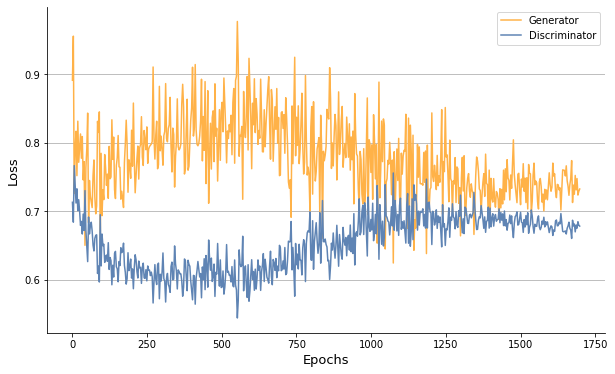

In [13]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
rr = range(0,len(gloss), 3)
short_g_loss = [gloss[i] for i in rr]
short_d_loss = [dloss[i] for i in rr]
#plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(rr, short_g_loss, label="Generator", color="#FFB248")
plt.plot(rr, short_d_loss, label="Discriminator", color="#5F84B4")
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.grid(axis="y")
plt.legend();

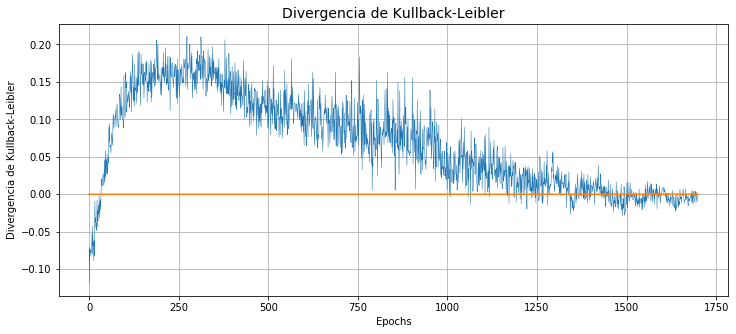

In [14]:
plt.figure(figsize=(12,5))
plt.title("Divergencia de Kullback-Leibler", fontsize=14)
plt.plot(range(len(utils.kl_d)), utils.kl_d, linewidth=.5)
plt.plot(range(len(utils.kl_d)), np.zeros(len(utils.kl_d)))
plt.grid()
plt.xlabel("Epochs");
plt.ylabel("Divergencia de Kullback-Leibler");

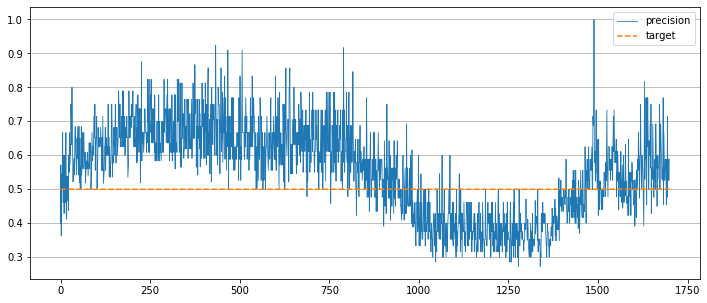

In [15]:
fig = plt.figure(figsize=(12,5))
plt.plot(range(len(utils.precision)), utils.precision, linewidth=.8, label="precision")
plt.grid(axis="y")
plt.plot(range(len(utils.precision)), np.ones(len(utils.precision))*.5, label="target", linestyle="--")
plt.legend();

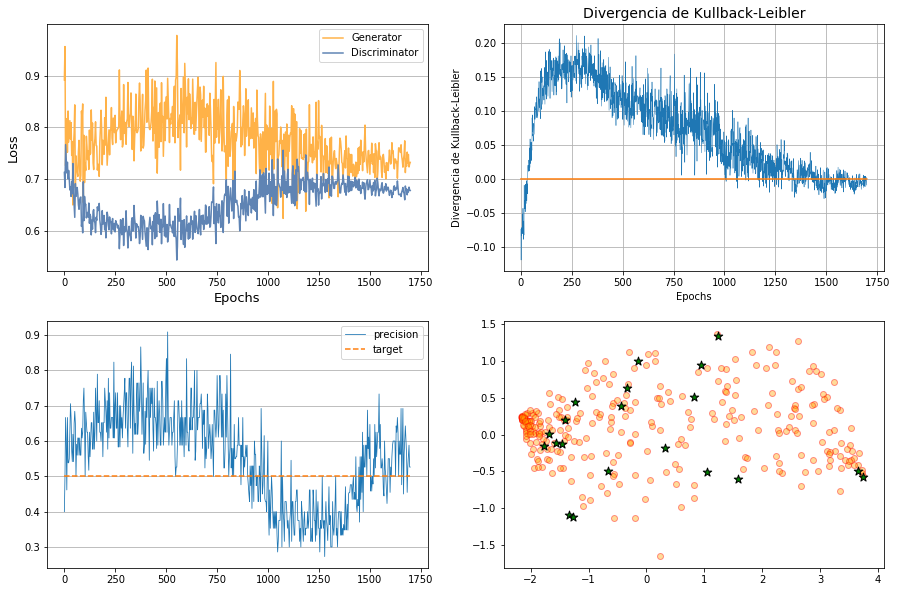

In [16]:
p = utils.plot_results(syn_size=300)

In [43]:
def boxtplot_values(v):
    """
    parameters: 
        v: array with the values to make a boxplot
    return the values to plot a boxplot in the bokeh library
    return: [lower, quantile25, quantile50, quantile75, upper] and outliers
    """
    q25 = np.quantile(v, q=.25, interpolation="midpoint")
    q50 = np.quantile(v, q=.5, interpolation="midpoint")
    q75 = np.quantile(v, q=.75, interpolation="midpoint")
    lower = q25 - 1.5*(q75-q25)
    upper = q75 + 1.5*(q75-q25)
    #outliers
    outliers = v[(v<lower)|(v>upper)]

    return [lower, q25, q50, q75, upper], outliers

In [44]:
p_d, kld, l_g, l_d = utils.get_metrics(num_iter=300)

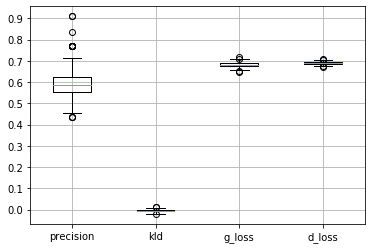

In [45]:
plt.boxplot([p_d, kld, l_g, l_d]);
#plt.yscale("logit")
plt.grid(axis="both");
plt.xticks(ticks=[1,2,3,4], labels=["precision", "kld", "g_loss", "d_loss"]);
plt.yticks(ticks=np.arange(0,1,.1), labels=np.round(np.arange(0,1.1,.1), 2));

#### Boxplot with Bokeh library
- I'm using the bokeh library to make a better plot.

In [150]:
from bokeh.plotting import output_notebook, figure, show, output_file
from bokeh.layouts import gridplot
from bokeh.palettes import OrRd, Greens, Set3, RdYlBu, YlGnBu
output_notebook()

[pl, pq1, pq2, pq3, pu], pouts = boxtplot_values(np.array(p_d))
[kldl, kldq1, kldq2, kldq3, kldu], kldouts = boxtplot_values(np.array(kld))
[lgl, lgq1, lgq2, lgq3, lgu], lgouts = boxtplot_values(np.array(l_g))
[ldl, ldq1, ldq2, ldq3, ldu], ldouts = boxtplot_values(np.array(l_d))

Loading BokehJS ...

In [153]:
#precision of the discriminator network
cats = ["Discriminador"]
p = figure(tools="", background_fill_color="#ffffff", x_range=cats, toolbar_location=None,
          plot_height=250, plot_width=220, )
p.segment(cats, [pl], cats, [pq1], line_color="black")
p.segment(cats, [pq3], cats, [pu], line_color="black")
p.vbar(cats, 0.2, [pq1], [pq2], fill_color="#E08E79", line_color="black")
p.vbar(cats, 0.2, [pq2], [pq3], fill_color="#3B8686", line_color="black")
p.rect(cats, [pl], 0.2, 0.0001, line_color="black")
p.rect(cats, [pu], 0.2, 0.0001, line_color="black")
p.circle([cats[0] for i in range(len(np.unique(pouts)))], np.unique(pouts),
         size=6, color="#F38630", fill_alpha=0.6, legend="outliers")
p.legend.background_fill_alpha = 0.0
p.yaxis.axis_label = "Precisão"
#p.legend.location = (80, 100)

#Kullback-Leibler divergence
p1 = figure(tools="", background_fill_color="#ffffff", x_range=cats, toolbar_location=None,
          plot_height=250, plot_width=220, )
p1.segment(cats, [kldl], cats, [kldq1], line_color="black")
p1.segment(cats, [kldq3], cats, [kldu], line_color="black")
p1.vbar(cats, 0.23, [kldq1], [kldq2], fill_color=Set3[3][0], line_color="black")
p1.vbar(cats, 0.23, [kldq2], [kldq3], fill_color=Set3[3][2], line_color="black")
p1.rect(cats, [kldl], 0.2, 0.0001, line_color="black")
p1.rect(cats, [kldu], 0.2, 0.0001, line_color="black")
p1.circle([cats[0] for i in range(len(np.unique(kldouts)))], np.unique(kldouts),
         size=6, color="#F38630", fill_alpha=0.6, legend="outliers")
p1.legend.background_fill_alpha = 0.0
p1.yaxis.axis_label = "Divergência de Kullback-Leibler"

#cost function of the generator network
cats_g = ["Generador"]
p2 = figure(tools="", background_fill_color="#ffffff", x_range=cats_g, toolbar_location=None,
          plot_height=250, plot_width=220, )
p2.segment(cats_g, [lgl], cats_g, [lgq1], line_color="black")
p2.segment(cats_g, [lgq3], cats_g, [lgu], line_color="black")
p2.vbar(cats_g, 0.23, [lgq1], [lgq2], fill_color=RdYlBu[3][0], line_color="black")
p2.vbar(cats_g, 0.23, [lgq2], [lgq3], fill_color=RdYlBu[3][1], line_color="black")
p2.rect(cats_g, [lgl], 0.2, 0.0001, line_color="black")
p2.rect(cats_g, [lgu], 0.2, 0.0001, line_color="black")
p2.circle([cats_g[0] for i in range(len(np.unique(lgouts)))], np.unique(lgouts),
         size=6, color="#F38630", fill_alpha=0.6, legend="outliers")
p2.legend.background_fill_alpha = 0.0
p2.yaxis.axis_label = "Função de custo"

#cost function of the discriminator network
p3 = figure(tools="", background_fill_color="#ffffff", x_range=cats, toolbar_location=None,
          plot_height=250, plot_width=220, )
p3.segment(cats, [ldl], cats, [ldq1], line_color="black")
p3.segment(cats, [ldq3], cats, [ldu], line_color="black")
p3.vbar(cats, 0.23, [ldq1], [ldq2], fill_color=YlGnBu[3][0], line_color="black")
p3.vbar(cats, 0.23, [ldq2], [ldq3], fill_color=YlGnBu[3][1], line_color="black")
p3.rect(cats, [ldl], 0.2, 0.0001, line_color="black")
p3.rect(cats, [ldu], 0.2, 0.0001, line_color="black")
p3.circle([cats[0] for i in range(len(np.unique(ldouts)))], np.unique(ldouts),
         size=6, color="#F38630", fill_alpha=0.6, legend="outliers")
p3.legend.background_fill_alpha = 0.0
p3.yaxis.axis_label = "Função de custo"


show(gridplot([[p, p1],[p2, p3]], plot_width=280))